# Credit Risk & Loan Default Machine Learning 

This is the Machine Learning aspect of the credit risk and loan default project. We will build a model that predicts 

0 = defaulted or Likely to Default

1 = Fully Paid

In [15]:
# Regular EDA tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

# Scikit-Learn models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

#Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score, confusion_matrix, classification_report, 
    matthews_corrcoef, cohen_kappa_score
)

In [2]:
# Load df

df = pd.read_csv('cleaned_df.csv')

In [3]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_status_new
0,2500,2500,2500.0,13.56,84.92,C,C1,10.0,RENT,55000.0,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,0,1.0
1,30000,30000,30000.0,18.94,777.23,D,D2,10.0,MORTGAGE,90000.0,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,0,1.0
2,5000,5000,5000.0,17.97,180.69,D,D1,6.0,MORTGAGE,59280.0,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,0,1.0
3,4000,4000,4000.0,18.94,146.51,D,D2,10.0,MORTGAGE,92000.0,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,0,1.0
4,30000,30000,30000.0,16.14,731.78,C,C4,10.0,MORTGAGE,57250.0,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218716 entries, 0 to 1218715
Data columns (total 96 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1218716 non-null  int64  
 1   funded_amnt                 1218716 non-null  int64  
 2   funded_amnt_inv             1218716 non-null  float64
 3   int_rate                    1218716 non-null  float64
 4   installment                 1218716 non-null  float64
 5   grade                       1218716 non-null  object 
 6   sub_grade                   1218716 non-null  object 
 7   emp_length                  1218716 non-null  float64
 8   home_ownership              1218716 non-null  object 
 9   annual_inc                  1218716 non-null  float64
 10  verification_status         1218716 non-null  object 
 11  issue_d                     1218716 non-null  object 
 12  pymnt_plan                  1218716 non-null  object 
 1

In [5]:
df['loan_status_new'] = df['loan_status_new'].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218716 entries, 0 to 1218715
Data columns (total 96 columns):
 #   Column                      Non-Null Count    Dtype   
---  ------                      --------------    -----   
 0   loan_amnt                   1218716 non-null  int64   
 1   funded_amnt                 1218716 non-null  int64   
 2   funded_amnt_inv             1218716 non-null  float64 
 3   int_rate                    1218716 non-null  float64 
 4   installment                 1218716 non-null  float64 
 5   grade                       1218716 non-null  object  
 6   sub_grade                   1218716 non-null  object  
 7   emp_length                  1218716 non-null  float64 
 8   home_ownership              1218716 non-null  object  
 9   annual_inc                  1218716 non-null  float64 
 10  verification_status         1218716 non-null  object  
 11  issue_d                     1218716 non-null  object  
 12  pymnt_plan                  1218716 non-nu

In [7]:
df.shape

(1218716, 96)

### IMPORTANT NOTE ABOUT DATA

Looking at your dataset, features such as:

**total_pymnt, total_rec_prncp, total_rec_int, recoveries, collection_recovery_fee, last_pymnt_amnt, last_pymnt_d**

These are all post-loan-issuance variables — they literally contain information about whether the loan was paid or defaulted.

Impact: Any model that sees these at training can perfectly predict loan_status_new, leading to F1 ≈ 0.99.

This will lead to unrealistically high F1-scores.

Solution: You must remove all features that occur after loan issuance or that “leak” the outcome. Focus only on information available at the time the loan is issued, e.g.:

loan_amnt, term, int_rate, emp_length, annual_inc, home_ownership, grade, sub_grade, dti, purpose, addr_state, etc.

In [8]:
# Keep only pre-loan features (remove post-loan info)
# --------------------------
post_loan_features = [
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
    'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d'
]
X = df.drop(columns=['loan_status_new'] + post_loan_features)
y = df['loan_status_new']


### 1. Split Data First (Avoid Leakage)
Before scaling, encoding, or balancing — split into train/test so that test data stays untouched.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#We use stratify=y to preserve class distribution.

In [12]:
# --------------------------
# Detect categorical & numeric columns
# --------------------------
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]


SVM and Logistic Regression assume features are on comparable scales so needs scaling.

Tree-based models (XGBoost, RandomForest, LightGBM) don’t need scaling.

So the next step after SMOTE is to scale your features before training.

Already, we have:

X_train_res, y_train_res (balanced training set after SMOTE)

X_test_encoded_df, y_test (untouched test set)

Now we will perform the following in one go:

1.) Scaling (only applied where needed)

2.) SMOTE for imbalance

3.) Model training (LogReg, SVM, RF, XGB)

### Reduce Sample Size for Faster Training

As we have over 1m samples to train we have less resorces for this, we reduce sample size to accommodate what we have.

In [17]:
# --------------------------
# Reduce sample size for speed (optional)
# --------------------------
SAMPLE_SIZE = 10000
if len(X_train) > SAMPLE_SIZE:
    X_train = X_train.sample(n=SAMPLE_SIZE, random_state=42)
    y_train = y_train.loc[X_train.index]

# --------------------------
# Define models
# --------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    ),
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True)
}


### Training and Evaluation

In [18]:
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Pipeline: OneHotEncode → Scale → SMOTE → Model
    clf = ImbPipeline(steps=[
        ('preprocessor', ColumnTransformer([
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
            ('num', 'passthrough', numeric_cols)
        ])),
        ('scaler', StandardScaler(with_mean=False)),  # keep with_mean=False for sparse OHE
        ('smote', SMOTE(random_state=42, n_jobs=-1, k_neighbors=3)),
        ('model', model)
    ])
    
    # Cross-validation F1
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    print(f"{name} F1 (CV mean): {scores.mean():.4f}")
    
    # Fit on full training set
    clf.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Compute metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'PR-AUC': average_precision_score(y_test, y_proba),
        'MCC': matthews_corrcoef(y_test, y_pred),
        'Cohen Kappa': cohen_kappa_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }


Training Logistic Regression...
Logistic Regression F1 (CV mean): 0.9107


/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(



Training Random Forest...
Random Forest F1 (CV mean): 0.9833


/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(



Training XGBoost...
XGBoost F1 (CV mean): 0.9833


/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(



Training SVM...


/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base

SVM F1 (CV mean): 0.9019


/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/fola-ai/tensorflow-test/env/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base

KeyboardInterrupt: 


=== Logistic Regression ===
Accuracy: 0.8714
Precision: 0.9384
Recall: 0.8897
F1: 0.9134
ROC-AUC: 0.9155
PR-AUC: 0.9631
MCC: 0.6683
Cohen Kappa: 0.6647


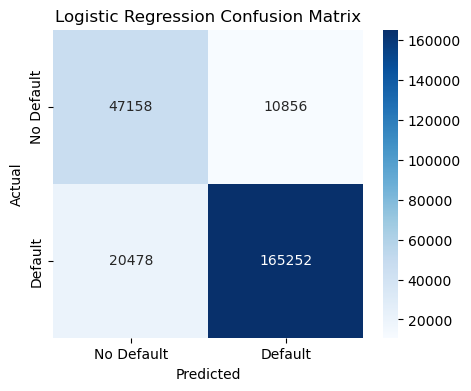


=== Random Forest ===
Accuracy: 0.9722
Precision: 0.9725
Recall: 0.9917
F1: 0.9820
ROC-AUC: 0.9683
PR-AUC: 0.9847
MCC: 0.9226
Cohen Kappa: 0.9218


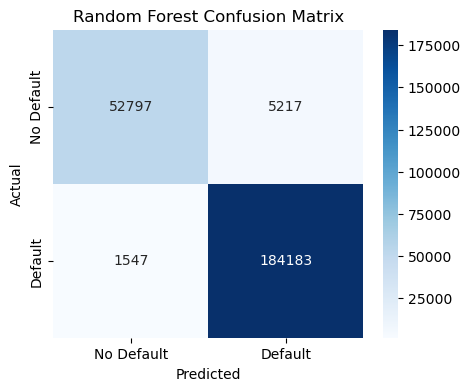


=== XGBoost ===
Accuracy: 0.9717
Precision: 0.9720
Recall: 0.9914
F1: 0.9816
ROC-AUC: 0.9663
PR-AUC: 0.9835
MCC: 0.9209
Cohen Kappa: 0.9201


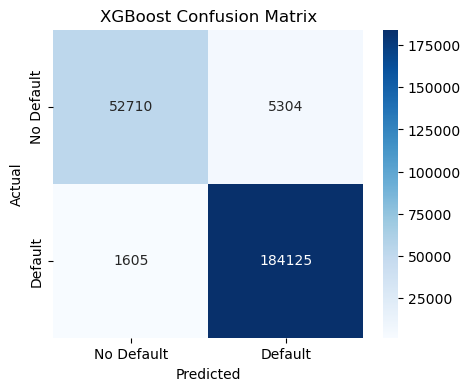

In [19]:
### Visualize the results

for model_name, metrics in results.items():
    print(f"\n=== {model_name} ===")
    for metric, value in metrics.items():
        if metric != 'Confusion Matrix':
            print(f"{metric}: {value:.4f}")
    # Confusion matrix heatmap
    cm = metrics['Confusion Matrix']
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default','Default'], yticklabels=['No Default','Default'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### Performance Metrics explanation:

1. **Accuracy**

*accuracy = accuracy_score(y_test, y_pred)*

Definition: Ratio of correctly predicted samples to total samples.

Why it matters: It’s the most straightforward metric.
When to use: When classes are balanced (e.g., 50/50 fraud vs non-fraud).
Limitations: Can be misleading in imbalanced datasets. Example: if 95% are “paid” loans, predicting all loans as “paid” gives 95% accuracy but is useless.

2. **Precision**

*precision = precision_score(y_test, y_pred)*

Definition: Out of all predicted positives, how many are actually positive?

Precision
Why it matters: Precision measures false alarms.
When to use: Critical in fraud detection, spam filtering, medical diagnosis — where false positives are costly.
Example: If we predict 100 people as defaulters but only 60 really are, precision = 60%.

3. **Recall (Sensitivity, True Positive Rate)**

*recall = recall_score(y_test, y_pred)*

Definition: Out of all actual positives, how many did the model correctly identify?

Recall

Recall= 
TP+FN
TP
​
 
Why it matters: Recall measures missed positives.
When to use: Important when false negatives are costly (e.g., missing cancer patients, failing to catch fraud).
Example: If there are 100 actual loan defaulters but model catches only 70, recall = 70%.

4. **F1 Score**

*f1 = f1_score(y_test, y_pred)*

Definition: Harmonic mean of precision and recall.

F1=2× 
Precision+Recall
Precision×Recall
​
 
Why it matters: Balances both false positives and false negatives.

When to use: Especially useful in imbalanced datasets (like your ~3:1 loans dataset).

5. **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**

*roc_auc = roc_auc_score(y_test, y_pred_proba)*

Definition: Measures how well the model separates the classes.
Why it matters: Independent of classification threshold.
When to use: Great for comparing models across thresholds.

Interpretation:

0.5 = random guessing

0.7–0.8 = acceptable

0.8–0.9 = good

0.9–1.0 = excellent

6. **PR-AUC (Precision-Recall AUC)**

*pr_auc = average_precision_score(y_test, y_pred_proba)*

Definition: Area under the Precision-Recall curve.

Why it matters: More informative than ROC-AUC on highly imbalanced datasets.
When to use: Your loan dataset is imbalanced (~3:1), so PR-AUC is more reliable than ROC-AUC.
Interpretation: Higher PR-AUC = better trade-off between catching defaulters and not misclassifying too many payers.

7. **Confusion Matrix**

*ConfusionMatrixDisplay.from_predictions(y_test, y_pred)*

Definition: Table that shows True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN).
Why it matters: Gives granular insight into model errors.
When to use: Always. It’s the foundation for precision, recall, etc.

Example:

              Predicted
            | Paid | Defaulted
Actual Paid |  900 |    100
Defaulted   |   50 |    150
✅ Summary of importance by scenario:

Balanced data → Accuracy, ROC-AUC.

Imbalanced data (like loans) → Precision, Recall, F1, PR-AUC.

High cost of false negatives (e.g., cancer, fraud) → Recall, F1.

High cost of false positives (e.g., spam, unnecessary interventions) → Precision.

